Housekeeping

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.optimize import fsolve
import itertools

from f_detrend import detrend_fuction

sn.set_style('whitegrid')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Auxiliary functions

In [59]:
# Expanded and modified version (first column now string)
def read_table(filename,keyword='ciclo',rescale=1,ncols=5,start=2,end_row='Total',
               endword=None,omit_list=['t20_21'],index_to_int=True,debug=False):
    t0 = start
    t1 = ncols+start
    results_follow = 0
    row_names = []
    f = open(filename,'r')
    for line in f:
        words = line.split()
        if debug:
            print(words)
        if len(words)>1 and words[0] == keyword:
            results_follow=1
            if endword==None:
                colnames = words[t0:t1]
            else:
                buff_v = []
                for w in words[t0:]:
                    if w==endword:
                        break
                    else:
                        buff_v.append(w)
                colnames = buff_v[:-1]
                t1 = len(buff_v)+t0-1
            table_raw = np.empty(t1-t0)
        elif len(words)>1 and words[0] == end_row:
            break
        elif len(words)>1 and results_follow==1 and words[0] not in omit_list:
            row_names.append(words[0])
            buff_v = []
            for w in words[t0:t1]: 
                w = w.replace(",","")
                buff_v.append(w)
            table_raw = np.vstack((table_raw,np.array(buff_v,dtype=float)/rescale))
    table_raw = table_raw[1:,:]
    if debug:
        print(table_raw.shape)
        print(colnames)
        print(table_raw)
    if index_to_int:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names,dtype=int))
    else:
        return pd.DataFrame(table_raw, columns=colnames,index=np.array(row_names))
    
    
def file_split(filename,path,startwords=['Summary',],endword="Total",header=None):
    f = open(path+filename,'r')
    parent_file = filename[:filename.find('.')]
    di = 1
    writing = 0
    for line in f:
        words = line.split()
        if len(words)>0 and words[0] in startwords:
            sf = open(path+parent_file+'_{}.log'.format(di), "w")
            writing = 1
            if header!=None:
                sf.write(header)
        elif len(words)>0 and words[0]==endword and writing:
            sf.write(line)
            writing = 0
            sf.close()
            di+=1
        if writing:
            sf.write(line)
            
def normalise_table(table):
    cols = table.columns
    table['Total'] = table.sum(axis=1).copy()
    for col in cols:
        table[col] = table[col]/table['Total']
    return table   

Date dictionaries

In [60]:
dates = []
for year in range(1987,2022):
    for quarter in range(1,5):
        dates.append(str(year)+"Q"+str(quarter))
dates = dates[1:]

t0 = 59
t05 = 71
T = len(dates)
date_dict = dict(zip(range(t0,T+t0),dates))
date_dict_reverse = dict(zip(dates,range(0,T)))
date_dict_reverse_ciclo = dict(zip(dates,range(t0,T+t0)))

<a id='index'></a>


# Quantile regressions for tenure: coefficients by year

### Women, 30-40 with age controls

Jump to

 - [Men 30-40](#urgh_3035)
 
 
  - [Employment regresssions](#employment)
 
 
 - [Women, extensive margin, 30-35](#women_ext_3035)
 --------------
 Split result tables
 --------------
 Split result tables

In [61]:
path = './results/'
name = "sqtreg_mothers_age3040_10_agefix"

file_split(name+'.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="wife_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25 = read_table(path+name+'_1.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['|','period_y'],index_to_int=False)
tab_moms_45_50 = read_table(path+name+'_2.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['period_y'],index_to_int=False)
tab_moms_45_75 = read_table(path+name+'_3.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['period_y'],index_to_int=False)

name = "sqtreg_mothers_0k_age3040_10_agefix"
file_split('sqtreg_mothers_0k_age3040_10_agefix.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="wife_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25_0k = read_table(path+name+'_1.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['period_y'],index_to_int=False)
tab_moms_45_50_0k = read_table(path+name+'_2.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['period_y'],index_to_int=False)
tab_moms_45_75_0k = read_table(path+name+'_3.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['period_y'],index_to_int=False)

In [62]:
tab_moms_45_25_0k

,Coefficient,std,t,p_stat,lower_95,upper_95q25
hub_ten_y,0.144843,0.007730,18.74,0.000,0.129693,0.159993
hub_ten_y2,-0.004597,0.000352,-13.04,0.000,-0.005287,-0.003906
part_time,-1.219275,0.023003,-53.01,0.000,-1.264361,-1.174189
college,0.407999,0.040612,10.05,0.000,0.328399,0.487599
less_hs,-0.511482,0.098893,-5.17,0.000,-0.705313,-0.317651
hub_age,-0.002321,0.003810,-0.61,0.542,-0.009790,0.005147
hub_se,-0.003668,0.045464,-0.08,0.936,-0.092777,0.085441
hub_college,-0.064583,0.034286,-1.88,0.060,-0.131783,0.002617
hub_less_hs,-0.355166,0.108924,-3.26,0.001,-0.568658,-0.141675
t08_11,0.179029,0.045912,3.90,0.000,0.089043,0.269016


In [63]:
time_periods_thin = ['t08_11', 't11_14','t14_17', 't17_20', 't20', 't21', 't22']
time_periods_thin_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021','2022']
coeffs_period = {}
lower_95_period = {}
upper_95_period = {}
all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))

for q in [25,50,75]:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)

    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs[q]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs[q]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs[q]['upper_95q{}'.format(q)][period]))
    coeffs_period[q] = coeffs.copy()
    lower_95_period[q] = lower.copy()
    upper_95_period[q] = upper.copy()


In [64]:
coeffs_period_0k = {}
lower_95_period_0k = {}
upper_95_period_0k = {}
all_tabs_0k = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

for q in [25,50,75]:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)

    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_0k[q]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_0k[q]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_0k[q]['upper_95q{}'.format(q)][period]))
    coeffs_period_0k[q] = coeffs.copy()
    lower_95_period_0k[q] = lower.copy()
    upper_95_period_0k[q] = upper.copy()


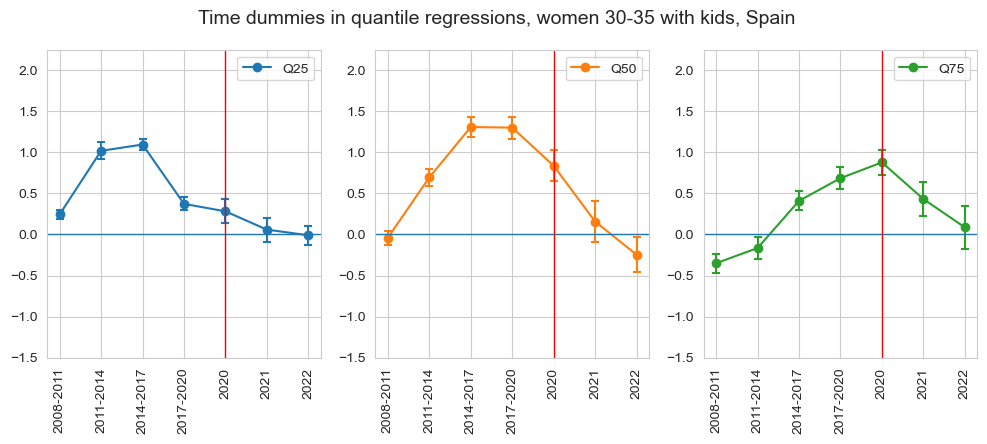

In [65]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(12,4))
plt.suptitle('Time dummies in quantile regressions, women 30-35 with kids, Spain',fontsize=14)
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.plot(np.arange(0,T*2,2),coeffs_period[q],marker='o', label='Q{}'.format(q),color=colors[j])
    plt.scatter(np.arange(0,T*2,2),lower_95_period[q],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period[q],marker='_',color=colors[j])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period[q][i],upper_95_period[q][i]),c=colors[j])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
    plt.legend()
    plt.axvline(8,c='r',lw=1)
    plt.ylim(-1.5,2.25)

#plt.savefig('./plots_tenure/qregs_spa_3040_time_dummies_women_kids.pdf',format='pdf',bbox_inches='tight')
plt.show()

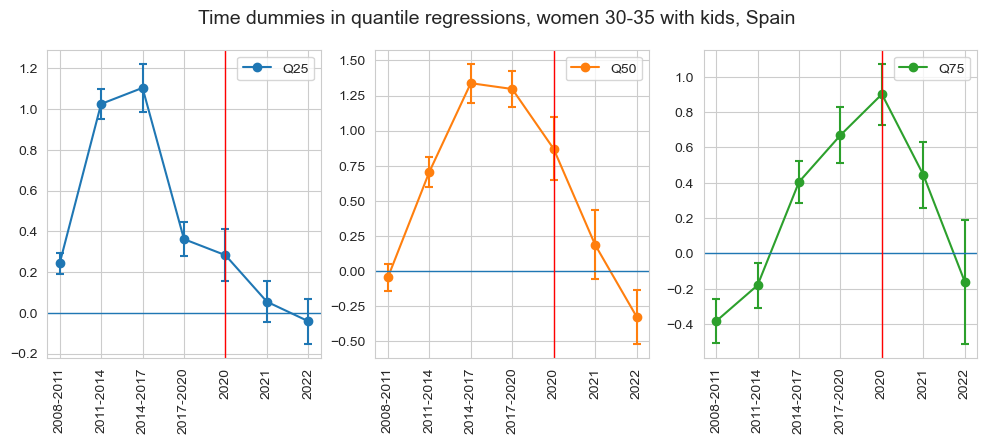

In [38]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(12,4))
plt.suptitle('Time dummies in quantile regressions, women 30-35 with kids, Spain',fontsize=14)
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.plot(np.arange(0,T*2,2),coeffs_period[q],marker='o', label='Q{}'.format(q),color=colors[j])
    plt.scatter(np.arange(0,T*2,2),lower_95_period[q],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period[q],marker='_',color=colors[j])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period[q][i],upper_95_period[q][i]),c=colors[j])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
    plt.legend()
    plt.axvline(8,c='r',lw=1)

#plt.savefig('./plots_tenure/qregs_spa_3035_time_dummies_women_kids.pdf',format='pdf',bbox_inches='tight')
plt.show()

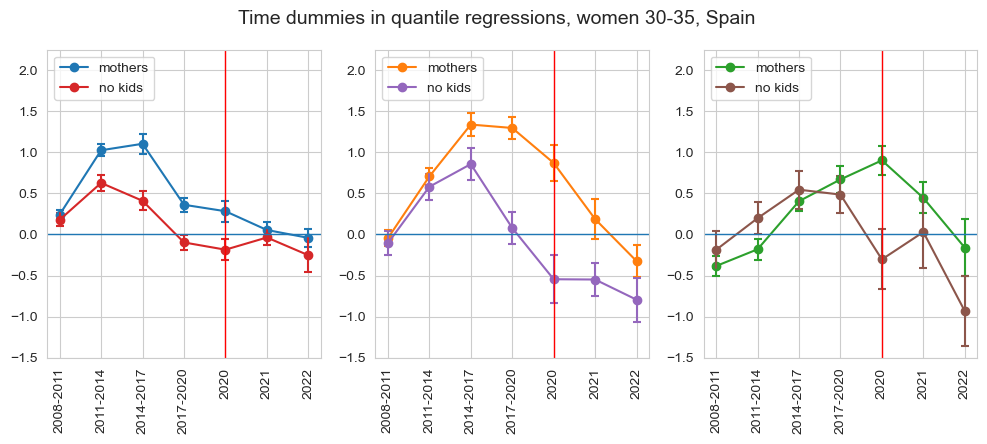

In [39]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(12,4))
plt.suptitle('Time dummies in quantile regressions, women 30-35, Spain',fontsize=14)
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.plot(np.arange(0,T*2,2),coeffs_period[q],marker='o', label='mothers'.format(q),color=colors[j])
    plt.scatter(np.arange(0,T*2,2),lower_95_period[q],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period[q],marker='_',color=colors[j])
    plt.plot(np.arange(0,T*2,2),coeffs_period_0k[q],marker='o', label='no kids'.format(q),color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),lower_95_period_0k[q],marker='_',color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_0k[q],marker='_',color=colors[j+3])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period[q][i],upper_95_period[q][i]),c=colors[j])
        plt.plot((i*2,i*2),(lower_95_period_0k[q][i],upper_95_period_0k[q][i]),c=colors[j+3])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
    plt.legend()
    plt.axvline(8,c='r',lw=1)
    plt.ylim(-1.5,2.25)

#plt.savefig('./plots_tenure/qregs_spa_3035_time_dummies_women_both.pdf',format='pdf',bbox_inches='tight')
plt.show()

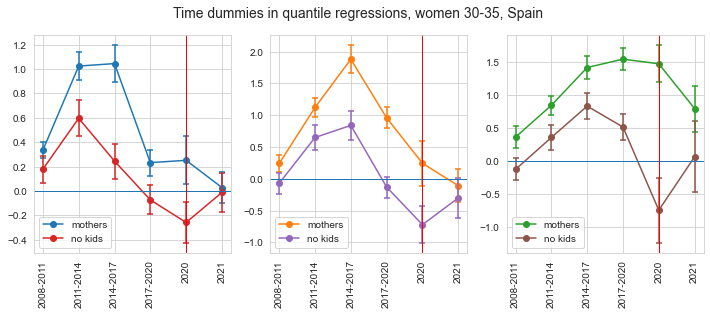

In [199]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(12,4))
plt.suptitle('Time dummies in quantile regressions, women 30-35, Spain',fontsize=14)
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.plot(np.arange(0,T*2,2),coeffs_period[q],marker='o', label='mothers'.format(q),color=colors[j])
    plt.scatter(np.arange(0,T*2,2),lower_95_period[q],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period[q],marker='_',color=colors[j])
    plt.plot(np.arange(0,T*2,2),coeffs_period_0k[q],marker='o', label='no kids'.format(q),color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),lower_95_period_0k[q],marker='_',color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_0k[q],marker='_',color=colors[j+3])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period[q][i],upper_95_period[q][i]),c=colors[j])
        plt.plot((i*2,i*2),(lower_95_period_0k[q][i],upper_95_period_0k[q][i]),c=colors[j+3])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
    plt.legend()
    plt.axvline(8,c='r',lw=1)

#plt.savefig('./plots_tenure/qregs_spa_3035_time_dummies_women_both.pdf',format='pdf',bbox_inches='tight')
plt.show()

<a id='urgh'></a>


## Quantile regressions for tenure: coefficients by year

### Men 30-40

Jump to

 - [Women 30-40](#women_3035)
 
 - [Women, extensive margin, 30-35](#women_ext_3035)
 --------------
 Split result tables

In [50]:
path = './results/'
name = "sqtreg_fathers_age3040_10_agefix"

file_split(name+'.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="hub_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_dads_45_25 = read_table(path+name+'_1.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['|','period_y'],index_to_int=False)
tab_dads_45_50 = read_table(path+name+'_2.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['period_y'],index_to_int=False)
tab_dads_45_75 = read_table(path+name+'_3.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['period_y'],index_to_int=False)

name = "sqtreg_fathers_0k_age3040_10_agefix"
file_split(name+'.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="hub_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_dads_45_25_0k = read_table(path+name+'_1.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['period_y'],index_to_int=False)
tab_dads_45_50_0k = read_table(path+name+'_2.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['period_y'],index_to_int=False)
tab_dads_45_75_0k = read_table(path+name+'_3.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['period_y'],index_to_int=False)

In [51]:
time_periods_thin = ['t08_11', 't11_14','t14_17', 't17_20', 't20', 't21', 't22']
time_periods_thin_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021','2022']
coeffs_period_m = {}
lower_95_period_m = {}
upper_95_period_m = {}
all_tabs_m = dict(zip([25,50,75],[tab_dads_45_25,tab_dads_45_50,tab_dads_45_75]))

for q in [25,50,75]:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)

    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_m[q]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_m[q]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_m[q]['upper_95q{}'.format(q)][period]))
    coeffs_period_m[q] = coeffs.copy()
    lower_95_period_m[q] = lower.copy()
    upper_95_period_m[q] = upper.copy()


In [52]:
time_periods_thin = ['t08_11', 't11_14','t14_17', 't17_20', 't20', 't21', 't22']
time_periods_thin_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021','2022']
coeffs_period_m_0k = {}
lower_95_period_m_0k = {}
upper_95_period_m_0k = {}
all_tabs_m_0k = dict(zip([25,50,75],[tab_dads_45_25_0k,tab_dads_45_50_0k,tab_dads_45_75_0k]))

for q in [25,50,75]:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)

    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_m_0k[q]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_m_0k[q]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_m_0k[q]['upper_95q{}'.format(q)][period]))
    coeffs_period_m_0k[q] = coeffs.copy()
    lower_95_period_m_0k[q] = lower.copy()
    upper_95_period_m_0k[q] = upper.copy()


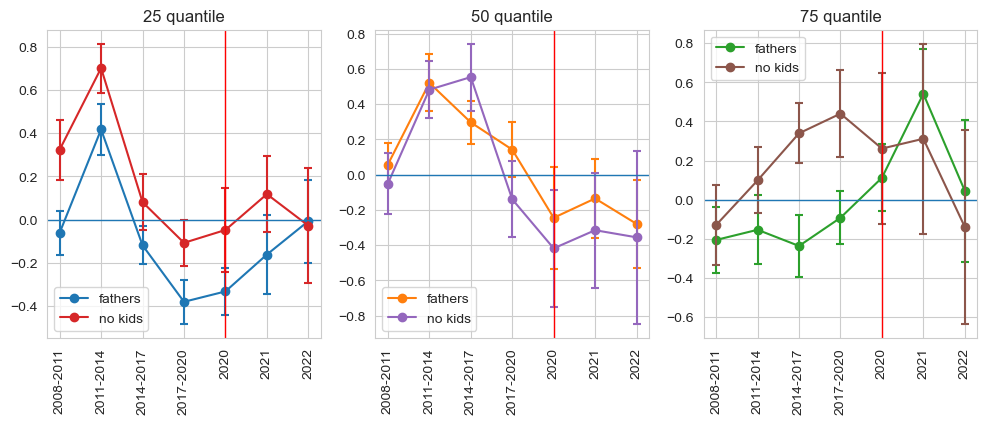

In [54]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(12,4))
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.title('{} quantile'.format(q))
    plt.plot(np.arange(0,T*2,2),coeffs_period_m[q],marker='o', label='fathers'.format(q),color=colors[j])
    plt.scatter(np.arange(0,T*2,2),lower_95_period_m[q],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_m[q],marker='_',color=colors[j])
    plt.plot(np.arange(0,T*2,2),coeffs_period_m_0k[q],marker='o', label='no kids'.format(q),color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),lower_95_period_m_0k[q],marker='_',color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_m_0k[q],marker='_',color=colors[j+3])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_m[q][i],upper_95_period_m[q][i]),c=colors[j])
        plt.plot((i*2,i*2),(lower_95_period_m_0k[q][i],upper_95_period_m_0k[q][i]),c=colors[j+3])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
    plt.legend()
    plt.axvline(8,c='r',lw=1)

# plt.savefig('./plots_tenure/qregs_spa_3035_time_dummies_men_both.pdf',format='pdf',bbox_inches='tight')
plt.show()

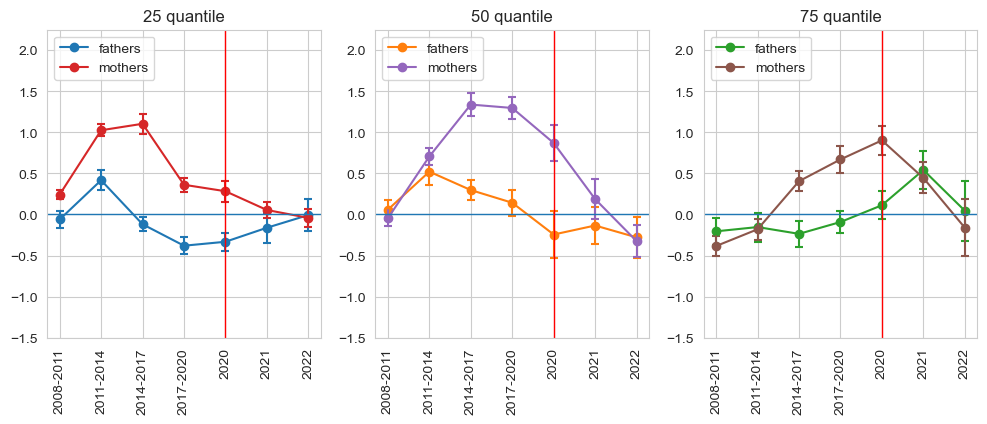

In [55]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(12,4))
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.title('{} quantile'.format(q))
    plt.plot(np.arange(0,T*2,2),coeffs_period_m[q],marker='o', label='fathers'.format(q),color=colors[j])
    plt.scatter(np.arange(0,T*2,2),lower_95_period_m[q],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_m[q],marker='_',color=colors[j])
    plt.plot(np.arange(0,T*2,2),coeffs_period[q],marker='o', label='mothers'.format(q),color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),lower_95_period[q],marker='_',color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),upper_95_period[q],marker='_',color=colors[j+3])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_m[q][i],upper_95_period_m[q][i]),c=colors[j])
        plt.plot((i*2,i*2),(lower_95_period[q][i],upper_95_period[q][i]),c=colors[j+3])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
    plt.legend()
    plt.axvline(8,c='r',lw=1)
    plt.ylim(-1.5,2.25)

# plt.savefig('./plots_tenure/qregs_spa_3035_time_dummies_men_both.pdf',format='pdf',bbox_inches='tight')
plt.show()

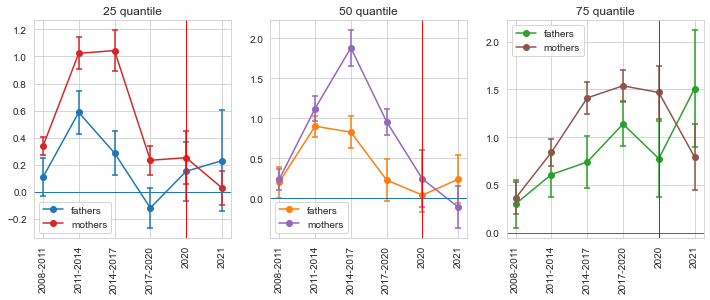

In [221]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(12,4))
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.title('{} quantile'.format(q))
    plt.plot(np.arange(0,T*2,2),coeffs_period_m[q],marker='o', label='fathers'.format(q),color=colors[j])
    plt.scatter(np.arange(0,T*2,2),lower_95_period_m[q],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_m[q],marker='_',color=colors[j])
    plt.plot(np.arange(0,T*2,2),coeffs_period[q],marker='o', label='mothers'.format(q),color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),lower_95_period[q],marker='_',color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),upper_95_period[q],marker='_',color=colors[j+3])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_m[q][i],upper_95_period_m[q][i]),c=colors[j])
        plt.plot((i*2,i*2),(lower_95_period[q][i],upper_95_period[q][i]),c=colors[j+3])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
    plt.legend()
    plt.axvline(8,c='r',lw=1)

# plt.savefig('./plots_tenure/qregs_spa_3035_time_dummies_men_both.pdf',format='pdf',bbox_inches='tight')
plt.show()

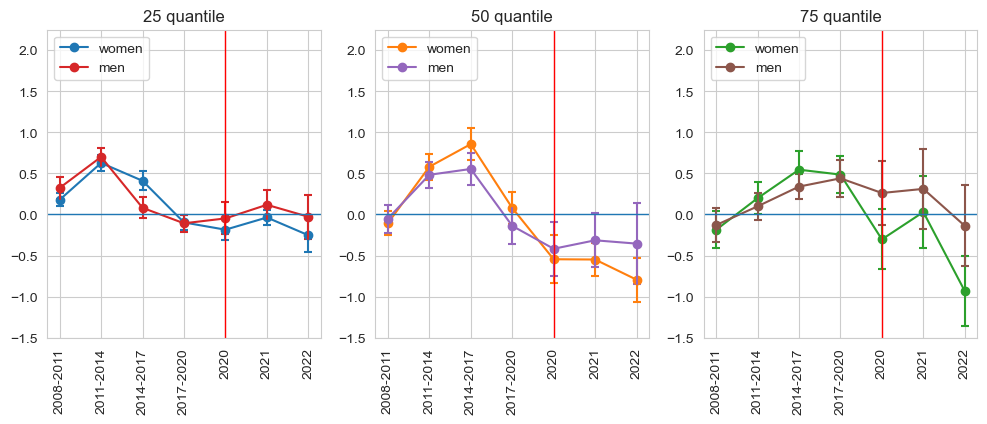

In [57]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(12,4))
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.title('{} quantile'.format(q))
    plt.plot(np.arange(0,T*2,2),coeffs_period_0k[q],marker='o', label='women'.format(q),color=colors[j])
    plt.scatter(np.arange(0,T*2,2),lower_95_period_0k[q],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_0k[q],marker='_',color=colors[j])
    plt.plot(np.arange(0,T*2,2),coeffs_period_m_0k[q],marker='o', label='men'.format(q),color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),lower_95_period_m_0k[q],marker='_',color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_m_0k[q],marker='_',color=colors[j+3])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_0k[q][i],upper_95_period_0k[q][i]),c=colors[j])
        plt.plot((i*2,i*2),(lower_95_period_m_0k[q][i],upper_95_period_m_0k[q][i]),c=colors[j+3])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
    plt.legend()
    plt.axvline(8,c='r',lw=1)
    plt.ylim(-1.5,2.25)

# plt.savefig('./plots_tenure/qregs_spa_3035_time_dummies_men_both.pdf',format='pdf',bbox_inches='tight')
plt.show()

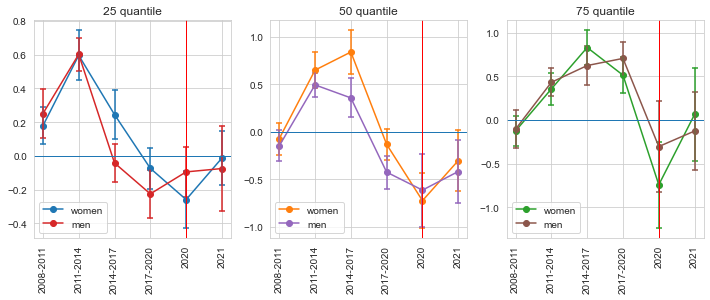

In [222]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(12,4))
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.title('{} quantile'.format(q))
    plt.plot(np.arange(0,T*2,2),coeffs_period_0k[q],marker='o', label='women'.format(q),color=colors[j])
    plt.scatter(np.arange(0,T*2,2),lower_95_period_0k[q],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_0k[q],marker='_',color=colors[j])
    plt.plot(np.arange(0,T*2,2),coeffs_period_m_0k[q],marker='o', label='men'.format(q),color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),lower_95_period_m_0k[q],marker='_',color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_m_0k[q],marker='_',color=colors[j+3])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_0k[q][i],upper_95_period_0k[q][i]),c=colors[j])
        plt.plot((i*2,i*2),(lower_95_period_m_0k[q][i],upper_95_period_m_0k[q][i]),c=colors[j+3])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
    plt.legend()
    plt.axvline(8,c='r',lw=1)

# plt.savefig('./plots_tenure/qregs_spa_3035_time_dummies_men_both.pdf',format='pdf',bbox_inches='tight')
# qregs_spa_3040_10_time_dummies_kids_agefix.pdf
plt.show()

<a id='employment'></a>

# Employment

Jump to
 - [Women <45](#index)
 - [Women 20-25](#women_3035)
 - [Men <45](#urgh)
 - [Men 30-35](#urgh_3035)
 
 
 - [Women, extensive margin, 30-35](#women_ext_3035)
 - [Men, extensive margin, 30-35](#men_ext_3035)

In [19]:
path = './results/'
emp_mothers_hemp = read_table(path+'logit_mothers_45_hemp.log',omit_list=['ccaa','act1','period_y'],end_row='_cons',
                              keyword='wife_emp',rescale=1,ncols=6,start=2,index_to_int=False)

emp_mothers_hemp_0k = read_table(path+'logit_mothers_45_hemp_0k.log',omit_list=['ccaa','act1','period_y'],end_row='_cons',
                              keyword='wife_emp',rescale=1,ncols=6,start=2,index_to_int=False)


header = ['Coefficient', 'std', 't', "p_stat", "lower_95", "upper_95"]
emp_mothers_hemp.rename(columns=dict(zip(emp_mothers_hemp.keys(),header)),inplace=True)
emp_mothers_hemp_0k.rename(columns=dict(zip(emp_mothers_hemp_0k.keys(),header)),inplace=True)

In [20]:
time_periods_thin = ['t08_11', 't11_14','t14_17', 't17_20', 't20', 't21','t22']
time_periods_thin_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021','2022']
coeffs_period_emp = {}
lower_95_period_emp = {}
upper_95_period_emp = {}
all_tabs_emp = dict(zip(['kids','no kids'],[emp_mothers_hemp,emp_mothers_hemp_0k]))

for kind in ['kids','no kids']:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)
    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_emp[kind]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_emp[kind]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_emp[kind]['upper_95'][period]))
    coeffs_period_emp[kind] = coeffs.copy()
    lower_95_period_emp[kind] = lower.copy()
    upper_95_period_emp[kind] = upper.copy()


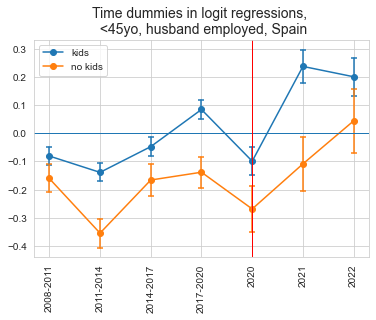

In [11]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(6,4))
plt.title('Time dummies in logit regressions, \n <45yo, husband employed, Spain',fontsize=14)
for j,kind in enumerate(['kids','no kids']):
    plt.plot(np.arange(0,T*2,2),coeffs_period_emp[kind],marker='o',color=colors[j],label=kind)
    plt.scatter(np.arange(0,T*2,2),lower_95_period_emp[kind],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_emp[kind],marker='_',color=colors[j])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_emp[kind][i],upper_95_period_emp[kind][i]),c=colors[j])
plt.axhline(0,lw=1)
plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
plt.legend()
plt.axvline(8,c='r',lw=1)

plt.show()

In [21]:
emp_fathers_hemp = read_table(path+'logit_fathers_45_hemp.log',omit_list=['age2','ccaa','act1','ocup1','period_y'],end_row='_cons',
                              keyword='hub_emp',rescale=1,ncols=6,start=2,index_to_int=False)

emp_fathers_hemp_0k = read_table(path+'logit_fathers_45_hemp_0k.log',omit_list=['age2','ccaa','act1','ocup1','period_y'],end_row='_cons',
                              keyword='hub_emp',rescale=1,ncols=6,start=2,index_to_int=False)


header = ['Coefficient', 'std', 't', "p_stat", "lower_95", "upper_95"]
emp_fathers_hemp.rename(columns=dict(zip(emp_fathers_hemp.keys(),header)),inplace=True)
emp_fathers_hemp_0k.rename(columns=dict(zip(emp_fathers_hemp_0k.keys(),header)),inplace=True)

time_periods_thin = ['t08_11', 't11_14','t14_17', 't17_20', 't20', 't21','t22']
time_periods_thin_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021','2022']
coeffs_period_emp_m = {}
lower_95_period_emp_m = {}
upper_95_period_emp_m = {}
all_tabs_emp_m = dict(zip(['kids','no kids'],[emp_fathers_hemp,emp_fathers_hemp_0k]))

for kind in ['kids','no kids']:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)
    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_emp_m[kind]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_emp_m[kind]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_emp_m[kind]['upper_95'][period]))
    coeffs_period_emp_m[kind] = coeffs.copy()
    lower_95_period_emp_m[kind] = lower.copy()
    upper_95_period_emp_m[kind] = upper.copy()


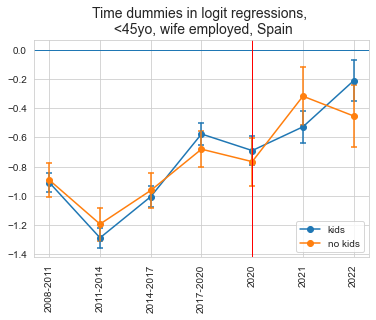

In [14]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(6,4))
plt.title('Time dummies in logit regressions, \n <45yo, wife employed, Spain',fontsize=14)
for j,kind in enumerate(['kids','no kids']):
    plt.plot(np.arange(0,T*2,2),coeffs_period_emp_m[kind],marker='o',color=colors[j],label=kind)
    plt.scatter(np.arange(0,T*2,2),lower_95_period_emp_m[kind],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_emp_m[kind],marker='_',color=colors[j])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_emp_m[kind][i],upper_95_period_emp_m[kind][i]),c=colors[j])
plt.axhline(0,lw=1)
plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
plt.legend()
plt.axvline(8,c='r',lw=1)

plt.show()

In [22]:
emp_mothers_hemp_30 = read_table(path+'logit_mothers_3035_hemp.log',omit_list=['ccaa','act1','period_y'],end_row='_cons',
                              keyword='wife_emp',rescale=1,ncols=6,start=2,index_to_int=False)

emp_mothers_hemp_0k_30 = read_table(path+'logit_mothers_3035_hemp_0k.log',omit_list=['ccaa','act1','period_y'],end_row='_cons',
                              keyword='wife_emp',rescale=1,ncols=6,start=2,index_to_int=False)


header = ['Coefficient', 'std', 't', "p_stat", "lower_95", "upper_95"]
emp_mothers_hemp_30.rename(columns=dict(zip(emp_mothers_hemp_30.keys(),header)),inplace=True)
emp_mothers_hemp_0k_30.rename(columns=dict(zip(emp_mothers_hemp_0k_30.keys(),header)),inplace=True)

time_periods_thin = ['t08_11', 't11_14','t14_17', 't17_20', 't20', 't21','t22']
time_periods_thin_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021','2022']
coeffs_period_emp_30 = {}
lower_95_period_emp_30 = {}
upper_95_period_emp_30 = {}
all_tabs_emp = dict(zip(['kids','no kids'],[emp_mothers_hemp_30,emp_mothers_hemp_0k_30]))

for kind in ['kids','no kids']:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)
    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_emp[kind]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_emp[kind]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_emp[kind]['upper_95'][period]))
    coeffs_period_emp_30[kind] = coeffs.copy()
    lower_95_period_emp_30[kind] = lower.copy()
    upper_95_period_emp_30[kind] = upper.copy()


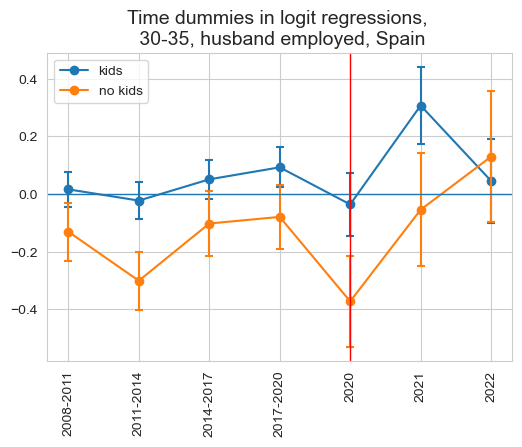

In [23]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(6,4))
plt.title('Time dummies in logit regressions, \n 30-35, husband employed, Spain',fontsize=14)
for j,kind in enumerate(['kids','no kids']):
    plt.plot(np.arange(0,T*2,2),coeffs_period_emp_30[kind],marker='o',color=colors[j],label=kind)
    plt.scatter(np.arange(0,T*2,2),lower_95_period_emp_30[kind],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_emp_30[kind],marker='_',color=colors[j])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_emp_30[kind][i],upper_95_period_emp_30[kind][i]),c=colors[j])
plt.axhline(0,lw=1)
plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
plt.legend()
plt.axvline(8,c='r',lw=1)

plt.show()

In [24]:
emp_mothers_hnemp_30 = read_table(path+'logit_mothers_3035_hnemp.log',omit_list=['ccaa','act1','period_y','51'],end_row='_cons',
                              keyword='wife_emp',rescale=1,ncols=6,start=2,index_to_int=False)

emp_mothers_hnemp_0k_30 = read_table(path+'logit_mothers_3035_hnemp_0k.log',omit_list=['ccaa','act1','period_y','51','52'],end_row='_cons',
                              keyword='wife_emp',rescale=1,ncols=6,start=2,index_to_int=False)


header = ['Coefficient', 'std', 't', "p_stat", "lower_95", "upper_95"]
emp_mothers_hnemp_30.rename(columns=dict(zip(emp_mothers_hnemp_30.keys(),header)),inplace=True)
emp_mothers_hnemp_0k_30.rename(columns=dict(zip(emp_mothers_hnemp_0k_30.keys(),header)),inplace=True)

time_periods_thin = ['t08_11', 't11_14','t14_17', 't17_20', 't20', 't21','t22']
time_periods_thin_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021','2022']
coeffs_period_nemp_30 = {}
lower_95_period_nemp_30 = {}
upper_95_period_nemp_30 = {}
all_tabs_emp = dict(zip(['kids','no kids'],[emp_mothers_hnemp_30,emp_mothers_hnemp_0k_30]))

for kind in ['kids','no kids']:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)
    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_emp[kind]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_emp[kind]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_emp[kind]['upper_95'][period]))
    coeffs_period_nemp_30[kind] = coeffs.copy()
    lower_95_period_nemp_30[kind] = lower.copy()
    upper_95_period_nemp_30[kind] = upper.copy()


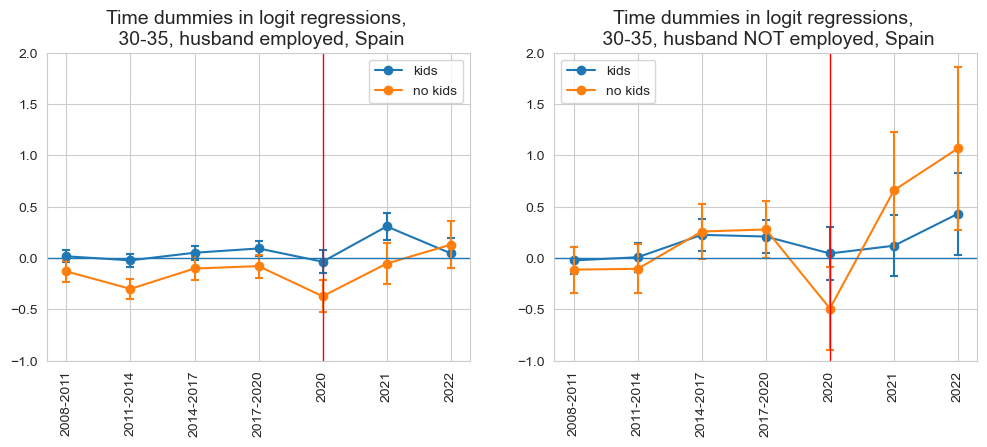

In [26]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title('Time dummies in logit regressions, \n 30-35, husband employed, Spain',fontsize=14)
for j,kind in enumerate(['kids','no kids']):
    plt.plot(np.arange(0,T*2,2),coeffs_period_emp_30[kind],marker='o',color=colors[j],label=kind)
    plt.scatter(np.arange(0,T*2,2),lower_95_period_emp_30[kind],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_emp_30[kind],marker='_',color=colors[j])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_emp_30[kind][i],upper_95_period_emp_30[kind][i]),c=colors[j])
plt.axhline(0,lw=1)
plt.ylim(-1.,2.0)
plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
plt.legend()
plt.axvline(8,c='r',lw=1)

plt.subplot(122)
plt.title('Time dummies in logit regressions, \n 30-35, husband NOT employed, Spain',fontsize=14)
for j,kind in enumerate(['kids','no kids']):
    plt.plot(np.arange(0,T*2,2),coeffs_period_nemp_30[kind],marker='o',color=colors[j],label=kind)
    plt.scatter(np.arange(0,T*2,2),lower_95_period_nemp_30[kind],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_nemp_30[kind],marker='_',color=colors[j])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_nemp_30[kind][i],upper_95_period_nemp_30[kind][i]),c=colors[j])
plt.axhline(0,lw=1)
plt.ylim(-1.0,2.0)
plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
plt.legend()
plt.axvline(8,c='r',lw=1)

plt.show()

In [35]:
emp_fathers_hemp = read_table(path+'logit_fathers_3035_hemp.log',omit_list=['age2','ccaa','act1','ocup1','period_y'],end_row='_cons',
                              keyword='hub_emp',rescale=1,ncols=6,start=2,index_to_int=False)

emp_fathers_hemp_0k = read_table(path+'logit_fathers_3035_hemp_0k.log',omit_list=['age2','ccaa','act1','ocup1','period_y'],end_row='_cons',
                              keyword='hub_emp',rescale=1,ncols=6,start=2,index_to_int=False)

emp_fathers_hnemp = read_table(path+'logit_fathers_3035_hnemp.log',omit_list=['52','0','9','ccaa','act1','ocup1','period_y'],end_row='_cons',
                              keyword='hub_emp',rescale=1,ncols=6,start=2,index_to_int=False)

emp_fathers_hnemp_0k = read_table(path+'logit_fathers_3035_hnemp_0k.log',omit_list=['52','0','9','age2','ccaa','act1','ocup1','period_y'],end_row='_cons',
                              keyword='hub_emp',rescale=1,ncols=6,start=2,index_to_int=False)



header = ['Coefficient', 'std', 't', "p_stat", "lower_95", "upper_95"]
emp_fathers_hnemp.rename(columns=dict(zip(emp_fathers_hnemp.keys(),header)),inplace=True)
emp_fathers_hnemp_0k.rename(columns=dict(zip(emp_fathers_hnemp_0k.keys(),header)),inplace=True)
emp_fathers_hemp.rename(columns=dict(zip(emp_fathers_hemp.keys(),header)),inplace=True)
emp_fathers_hemp_0k.rename(columns=dict(zip(emp_fathers_hemp_0k.keys(),header)),inplace=True)


time_periods_thin = ['t08_11', 't11_14','t14_17', 't17_20', 't20', 't21','t22']
time_periods_thin_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021','2022']
coeffs_period_emp_m = {}
lower_95_period_emp_m = {}
upper_95_period_emp_m = {}
all_tabs_emp_m = dict(zip(['kids','no kids'],[emp_fathers_hemp,emp_fathers_hemp_0k]))

for kind in ['kids','no kids']:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)
    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_emp_m[kind]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_emp_m[kind]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_emp_m[kind]['upper_95'][period]))
    coeffs_period_emp_m[kind] = coeffs.copy()
    lower_95_period_emp_m[kind] = lower.copy()
    upper_95_period_emp_m[kind] = upper.copy()
    
coeffs_period_nemp_m = {}
lower_95_period_nemp_m = {}
upper_95_period_nemp_m = {}
all_tabs_nemp_m = dict(zip(['kids','no kids'],[emp_fathers_hnemp,emp_fathers_hnemp_0k]))

for kind in ['kids','no kids']:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)
    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_nemp_m[kind]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_nemp_m[kind]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_nemp_m[kind]['upper_95'][period]))
    coeffs_period_nemp_m[kind] = coeffs.copy()
    lower_95_period_nemp_m[kind] = lower.copy()
    upper_95_period_nemp_m[kind] = upper.copy()


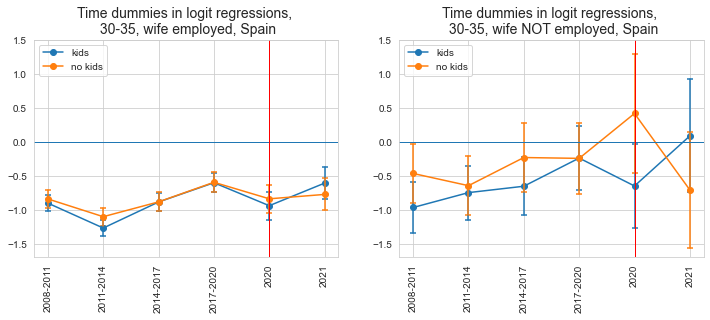

In [34]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title('Time dummies in logit regressions, \n 30-35, wife employed, Spain',fontsize=14)
for j,kind in enumerate(['kids','no kids']):
    plt.plot(np.arange(0,T*2,2),coeffs_period_emp_m[kind],marker='o',color=colors[j],label=kind)
    plt.scatter(np.arange(0,T*2,2),lower_95_period_emp_m[kind],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_emp_m[kind],marker='_',color=colors[j])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_emp_m[kind][i],upper_95_period_emp_m[kind][i]),c=colors[j])
plt.axhline(0,lw=1)
plt.ylim(-1.7,1.5)
plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
plt.legend()
plt.axvline(8,c='r',lw=1)

plt.subplot(122)
plt.title('Time dummies in logit regressions, \n 30-35, wife NOT employed, Spain',fontsize=14)
for j,kind in enumerate(['kids','no kids']):
    plt.plot(np.arange(0,T*2,2),coeffs_period_nemp_m[kind],marker='o',color=colors[j],label=kind)
    plt.scatter(np.arange(0,T*2,2),lower_95_period_nemp_m[kind],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_nemp_m[kind],marker='_',color=colors[j])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_nemp_m[kind][i],upper_95_period_nemp_m[kind][i]),c=colors[j])
plt.axhline(0,lw=1)
plt.ylim(-1.7,1.5)
plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
plt.legend()
plt.axvline(8,c='r',lw=1)

plt.show()

<a id='women_ext_3035'></a>


# Quantile regressions for tenure, extensive margin: coefficients by year

### Women, 35-45

Jump to
 - [Women <45](#index)
 - [Women 30-35](#women_3035)
 - [Men <45](#urgh)
 - [Men 30-35](#urgh_3035)
 
 
 - [Employment regresssions](#employment)
 
 --------------
 Split result tables
 --------------
 Split result tables

In [137]:
path = './results/'

file_split('sqtreg_mothers_3035_ext.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="wife_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25 = read_table(path+'sqtreg_mothers_3035_ext_1.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)
tab_moms_45_50 = read_table(path+'sqtreg_mothers_3035_ext_2.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)
tab_moms_45_75 = read_table(path+'sqtreg_mothers_3035_ext_3.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)

file_split('sqtreg_mothers_0k_3035_ext.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="wife_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_moms_45_25_0k = read_table(path+'sqtreg_mothers_0k_3035_ext_1.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)
tab_moms_45_50_0k = read_table(path+'sqtreg_mothers_0k_3035_ext_2.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)
tab_moms_45_75_0k = read_table(path+'sqtreg_mothers_0k_3035_ext_3.log',
                         keyword='wife_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)

In [138]:
time_periods_thin = ['t08_11', 't11_14','t14_17', 't17_20', 't20', 't21']
time_periods_thin_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021']
coeffs_period = {}
lower_95_period = {}
upper_95_period = {}
all_tabs = dict(zip([25,50,75],[tab_moms_45_25,tab_moms_45_50,tab_moms_45_75]))

for q in [25,50,75]:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)

    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs[q]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs[q]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs[q]['upper_95q{}'.format(q)][period]))
    coeffs_period[q] = coeffs.copy()
    lower_95_period[q] = lower.copy()
    upper_95_period[q] = upper.copy()


In [139]:
coeffs_period_0k = {}
lower_95_period_0k = {}
upper_95_period_0k = {}
all_tabs_0k = dict(zip([25,50,75],[tab_moms_45_25_0k,tab_moms_45_50_0k,tab_moms_45_75_0k]))

for q in [25,50,75]:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)

    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_0k[q]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_0k[q]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_0k[q]['upper_95q{}'.format(q)][period]))
    coeffs_period_0k[q] = coeffs.copy()
    lower_95_period_0k[q] = lower.copy()
    upper_95_period_0k[q] = upper.copy()


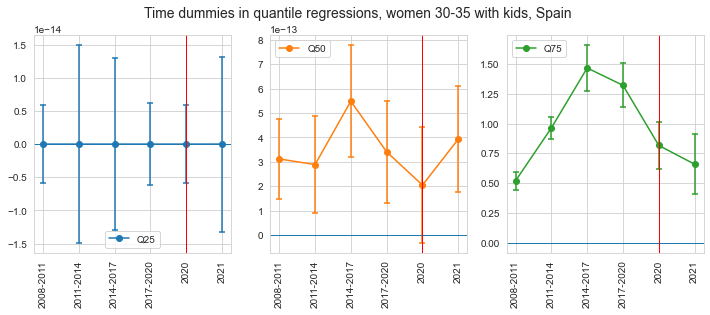

In [140]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(12,4))
plt.suptitle('Time dummies in quantile regressions, women 30-35 with kids, Spain',fontsize=14)
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.plot(np.arange(0,T*2,2),coeffs_period[q],marker='o', label='Q{}'.format(q),color=colors[j])
    plt.scatter(np.arange(0,T*2,2),lower_95_period[q],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period[q],marker='_',color=colors[j])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period[q][i],upper_95_period[q][i]),c=colors[j])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
    plt.legend()
    plt.axvline(8,c='r',lw=1)

plt.show()

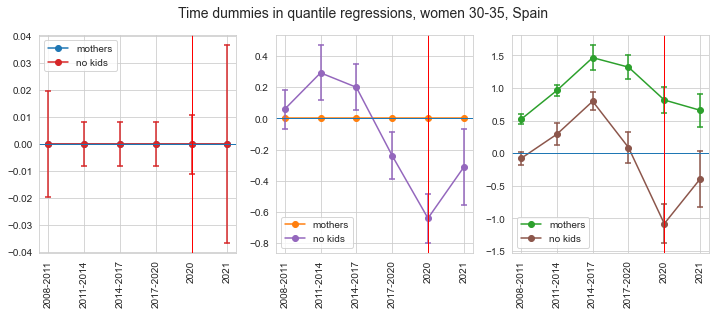

In [141]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(12,4))
plt.suptitle('Time dummies in quantile regressions, women 30-35, Spain',fontsize=14)
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.plot(np.arange(0,T*2,2),coeffs_period[q],marker='o', label='mothers'.format(q),color=colors[j])
    plt.scatter(np.arange(0,T*2,2),lower_95_period[q],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period[q],marker='_',color=colors[j])
    plt.plot(np.arange(0,T*2,2),coeffs_period_0k[q],marker='o', label='no kids'.format(q),color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),lower_95_period_0k[q],marker='_',color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_0k[q],marker='_',color=colors[j+3])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period[q][i],upper_95_period[q][i]),c=colors[j])
        plt.plot((i*2,i*2),(lower_95_period_0k[q][i],upper_95_period_0k[q][i]),c=colors[j+3])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
    plt.legend()
    plt.axvline(8,c='r',lw=1)

plt.show()

<a id='men_ext_3035'></a>

### Men, 35-45

Jump to
 - [Women <45](#index)
 - [Women 30-35](#women_3035)
 - [Men <45](#urgh)
 - [Men 30-35](#urgh_3035)
 
 
 - [Employment regresssions](#employment)
 
 
 - [Women extensive margin, 30-35](#women_ext_3035)
 
 --------------
 Split result tables

In [142]:
path = './results/'

file_split('sqtreg_fathers_3035_ext.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="hub_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_dads_45_25 = read_table(path+'sqtreg_fathers_3035_ext_1.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)
tab_dads_45_50 = read_table(path+'sqtreg_fathers_3035_ext_2.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)
tab_dads_45_75 = read_table(path+'sqtreg_fathers_3035_ext_3.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)

file_split('sqtreg_fathers_0k_3035_ext.log',path,startwords=['q25','q50','q75'],endword="_cons",
           header="hub_ten_y | Coefficient std t p_stat lower_95 upper_95")

tab_dads_45_25_0k = read_table(path+'sqtreg_fathers_0k_3035_ext_1.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)
tab_dads_45_50_0k = read_table(path+'sqtreg_fathers_0k_3035_ext_2.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)
tab_dads_45_75_0k = read_table(path+'sqtreg_fathers_0k_3035_ext_3.log',
                         keyword='hub_ten_y',rescale=1,ncols=6,start=2,omit_list=['age2','t20_21'],index_to_int=False)

In [118]:
time_periods_thin = ['t08_11', 't11_14','t14_17', 't17_20', 't20', 't21']
time_periods_thin_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021']
coeffs_period_m = {}
lower_95_period_m = {}
upper_95_period_m = {}
all_tabs_m = dict(zip([25,50,75],[tab_dads_45_25,tab_dads_45_50,tab_dads_45_75]))

for q in [25,50,75]:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)

    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_m[q]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_m[q]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_m[q]['upper_95q{}'.format(q)][period]))
    coeffs_period_m[q] = coeffs.copy()
    lower_95_period_m[q] = lower.copy()
    upper_95_period_m[q] = upper.copy()


In [119]:
time_periods_thin = ['t08_11', 't11_14','t14_17', 't17_20', 't20', 't21']
time_periods_thin_labels = ['2008-2011','2011-2014','2014-2017','2017-2020','2020','2021']
coeffs_period_m_0k = {}
lower_95_period_m_0k = {}
upper_95_period_m_0k = {}
all_tabs_m_0k = dict(zip([25,50,75],[tab_dads_45_25_0k,tab_dads_45_50_0k,tab_dads_45_75_0k]))

for q in [25,50,75]:
    coeffs,lower,upper = np.zeros(0),np.zeros(0),np.zeros(0)

    for period in time_periods_thin:
        coeffs = np.hstack((coeffs,all_tabs_m_0k[q]['Coefficient'][period]))
        lower = np.hstack((lower,all_tabs_m_0k[q]['lower_95'][period]))
        upper = np.hstack((upper,all_tabs_m_0k[q]['upper_95q{}'.format(q)][period]))
    coeffs_period_m_0k[q] = coeffs.copy()
    lower_95_period_m_0k[q] = lower.copy()
    upper_95_period_m_0k[q] = upper.copy()


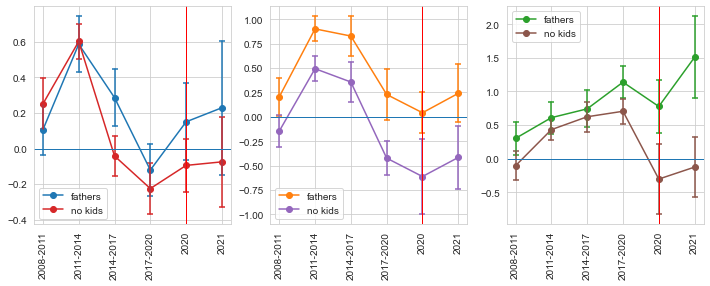

In [143]:
T = len(time_periods_thin)
colors = sn.color_palette()

plt.figure(figsize=(12,4))
for j,q in enumerate([25,50,75]):
    plt.subplot(131+j)
    plt.plot(np.arange(0,T*2,2),coeffs_period_m[q],marker='o', label='fathers'.format(q),color=colors[j])
    plt.scatter(np.arange(0,T*2,2),lower_95_period_m[q],marker='_',color=colors[j])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_m[q],marker='_',color=colors[j])
    plt.plot(np.arange(0,T*2,2),coeffs_period_m_0k[q],marker='o', label='no kids'.format(q),color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),lower_95_period_m_0k[q],marker='_',color=colors[j+3])
    plt.scatter(np.arange(0,T*2,2),upper_95_period_m_0k[q],marker='_',color=colors[j+3])
    for i in range(T):
        plt.plot((i*2,i*2),(lower_95_period_m[q][i],upper_95_period_m[q][i]),c=colors[j])
        plt.plot((i*2,i*2),(lower_95_period_m_0k[q][i],upper_95_period_m_0k[q][i]),c=colors[j+3])
    plt.axhline(0,lw=1)
    plt.xticks(np.arange(0,T*2,2),time_periods_thin_labels,rotation=90)
    plt.legend()
    plt.axvline(8,c='r',lw=1)

plt.show()